### Setup

In [6]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "intro_to_ANN"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


## The Perceptron

The Perceptron is one of the simplest ANN architectures, invented in 1957 by Frank Rosenblatt. It is based on a slightly different artificial neuron (see Figure 10-4) called a threshold logic unit (TLU), or sometimes a linear threshold unit (LTU)

The most common step function used in Perceptrons is the Heaviside step function (see Equation 10-1). Sometimes the sign function is used instead.

A single TLU can be used for `simple linear binary classification`. It computes a linear combination of the inputs, and if the result exceeds a threshold, it outputs the positive class. Otherwise it outputs the negative class (just like a Logistic Regression or linear SVM classifier). You could, for example, use a single TLU to classify iris flowers based on petal length and width (also adding an extra bias feature $x_0 = 1$, just like we did in previous chapters). Training a TLU in this case means finding the right values for $w_0$, $w_1$, and $w_2$ (the training algorithm is discussed shortly).

A Perceptron is simply composed of a single layer of TLUs, with each TLU connected to all the inputs. When all the neurons in a layer are connected to every neuron in the previous layer (i.e., its input neurons), the layer is called a **`fully connected layer, or a dense layer.`** The inputs of the Perceptron are fed to special passthrough neurons called input neurons: they output whatever input they are fed. All the input neurons form the input layer. Moreover, an extra bias feature is generally added ($x_0 = 1$): it is typically represented using a special type of neuron called a bias neuron, which outputs 1 all the time. A Perceptron with two inputs and three outputs is represented in Figure 10-5. **This Perceptron can classify instances simultaneously into three different binary classes, which makes it a `multioutput classifier`**.

The decision boundary of each output neuron is linear, so Perceptrons are incapable of learning complex patterns (just like Logistic Regression classifiers). However, if the training instances are linearly separable, Rosenblatt demonstrated that this algorithm would converge to a solution.8 This is called the `Perceptron convergence theorem`.
<br>

Scikit-Learn provides a **_Perceptron_** class that implements a single-TLU network. It can be used pretty much as you would expect—for example, on the iris dataset

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

In [2]:
iris = load_iris()

In [3]:
X = iris.data[:, (2, 3)] # petal length, petal width
y = (iris.target == 0).astype(np.int) # Iris setosa?

In [40]:
X.shape, y.shape

((150, 2), (150,))

In [7]:
per_clf = Perceptron()
per_clf.fit(X, y)

Perceptron()

In [8]:
y_pred = per_clf.predict([[2, 0.5]])

In [9]:
y_pred

array([0])

`You may have noticed that the Perceptron learning algorithm strongly resembles Stochastic Gradient Descent. In fact, Scikit-Learn’s Perceptron class is equivalent to using an SGDClassifier with the following hyperparameters: loss="perceptron", learning_rate="constant", eta0=1 (the learning rate), and penalty=None (no regularization).`
<br>

`Note that contrary to Logistic Regression classifiers, Perceptrons do not output a class probability; rather, they make predictions based on a hard threshold. This is one reason to prefer Logistic Regression over Perceptrons.`

In [14]:
per_clf.intercept_, per_clf.coef_

(array([2.]), array([[-0.7, -1.2]]))

Saving figure perceptron_iris_plot


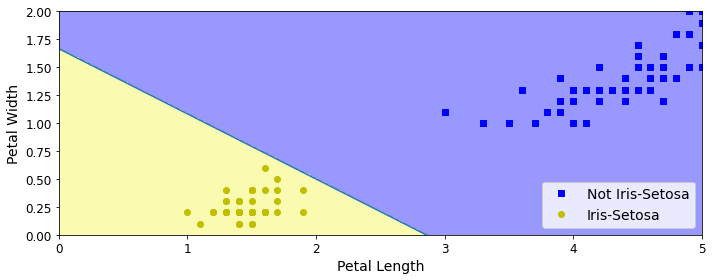

In [71]:
a = - per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = - per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

X0, X1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )

X_new = np.c_[X0.ravel(), X1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(X0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 0, 0], X[y == 0, 1], 'bs', label='Not Iris-Setosa')
plt.plot(X[y == 1, 0], X[y == 1, 1], 'yo', label='Iris-Setosa')

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b])

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(X0, X1, zz, cmap=custom_cmap)
plt.xlabel('Petal Length', fontsize=14)
plt.ylabel('Petal Width', fontsize=14)

plt.legend(loc='lower right', fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

In [47]:
X[0, :]

array([1.4, 0.2])

In [42]:
a, b, X0.shape, X1.shape, X0.ravel().shape, X_new.shape, y_predict.shape, zz.shape

(-0.5833333333333338,
 array([1.66666667]),
 (200, 500),
 (200, 500),
 (100000,),
 (100000, 2),
 (100000,),
 (200, 500))

## The Multilayer Perceptron and Backpropagation

An MLP is composed of one (passthrough) _input layer_, one or more layers of TLUs, called _hidden layers_, and one final layer of TLUs called the _output layer_ (see Figure 10-7). The layers close to the input layer are usually called the _lower layers_, and the ones close to the outputs are usually called the _upper layers_. Every layer except the output layer includes a bias neuron and is fully connected to the next layer.

![Architecture of a Multilayer Perceptron with two inputs, one hidden layer of four neurons, and three output neurons (the bias neurons are shown here, but usually they are implicit)](images/intro_to_ANN/architecture_of_multilayer_perceptron.png)

## NOTE

> The signal flows only in one direction (from the inputs to the outputs), so this architecture is an example of a **`feedforward neural network (FNN).`**

When an ANN contains a deep stack of hidden layers, it is called a **`deep neural network (DNN)`**.

### The Backpropagation training algorithm, 

It is still used today. In short, it is `Gradient Descent` (introduced in Chapter 4) using an efficient technique for **computing the gradients automatically**: in just two passes through the network (_one forward, one backward_), the backpropagation algorithm is able to compute the gradient of the network’s error with regard to every single model parameter. In other words, it can find out how each connection weight and each bias term should be tweaked in order to reduce the error. Once it has these gradients, it just performs a regular Gradient Descent step, and the whole process is repeated until the network converges to the solution.

## NOTE

> **Automatically computing gradients is called `automatic differentiation, or autodiff`. There are various autodiff techniques, with different pros and cons. `The one used by backpropagation is called reverse-mode autodiff`. It is fast and precise, and is well suited when the function to differentiate has many variables (e.g., connection weights) and few outputs (e.g., one loss). If you want to learn more about autodiff, check out Appendix D.**

`Let’s run through this algorithm in a bit more detail:`
* It handles one mini-batch at a time (for example, containing 32 instances each), and it goes through the full training set multiple times. Each pass is called an **`epoch`**.
* Each mini-batch is passed to the network’s input layer, which sends it to the first hidden layer. The algorithm then computes the output of all the neurons in this layer (for every instance in the mini-batch). The result is passed on to the next layer, its output is computed and passed to the next layer, and so on until we get the output of the last layer, the output layer. **`This is the forward pass`**: **`it is exactly like making predictions, except all intermediate results are preserved since they are needed for the backward pass.`**
* Next, the algorithm measures the network’s output error (i.e., it uses a `loss function that compares the desired output and the actual output of the network`\, and returns some measure of the error`).
* Then it computes how much each output connection contributed to the error. This is done analytically by applying the chain rule (perhaps the most fundamental rule in calculus), which makes this step fast and precise.
* The algorithm then measures how much of these error contributions came from each connection in the layer below, again using the chain rule, working backward until the algorithm reaches the input layer. As explained earlier, this reverse pass efficiently measures the error gradient across all the connection weights in the network by propagating the error gradient backward through the network (hence the name of the algorithm).
* Finally, the algorithm performs a Gradient Descent step to tweak all the connection weights in the network, using the error gradients it just computed.

<br>

> **_`This algorithm is so important that it’s worth summarizing it again: for each training instance, the backpropagation algorithm first makes a prediction (forward pass) and measures the error, then goes through each layer in reverse to measure the error contribution from each connection (reverse pass), and finally tweaks the connection weights to reduce the error (Gradient Descent step).`_**

## WARNING

> It is important to initialize all the hidden layers’ connection weights randomly, or else training will fail. For example, if you initialize all weights and biases to zero, then all neurons in a given layer will be perfectly identical, and thus backpropagation will affect them in exactly the same way, so they will remain identical. In other words, despite having hundreds of neurons per layer, your model will act as if it had only one neuron per layer: it won’t be too smart. If instead you randomly initialize the weights, you break the symmetry and allow backpropagation to train a diverse team of neurons.

### Activation Functions

In order for this algorithm to work properly, its authors made a key change to the MLP’s architecture: they replaced the step function with the logistic (sigmoid) function, $σ(z) = 1 / (1 + exp(–z))$. **`This was essential because the step function contains only flat segments, so there is no gradient to work with (Gradient Descent cannot move on a flat surface), while the logistic function has a well-defined nonzero derivative everywhere, allowing Gradient Descent to make some progress at every step.`** In fact, the backpropagation algorithm works well with many other activation functions, not just the logistic function. Here are two other popular choices:
<br>

* The `hyperbolic tangent` function: $tanh(z) = 2σ(2z) – 1$
    * Just like the logistic function, this activation function is S-shaped, continuous, and differentiable, but its output value ranges from –1 to 1 (instead of 0 to 1 in the case of the logistic function). That range tends to make each layer’s output more or less centered around 0 at the beginning of training, which often helps speed up convergence.
* The `Rectified Linear Unit` function: $ReLU(z) = max(0, z)$
    * The ReLU function is continuous but unfortunately not differentiable at $z= 0$ (the slope changes abruptly, which can make Gradient Descent bounce around), and its derivative is $0$ for $z < 0$. In practice, however, it works very well and has the advantage of being fast to compute, so it has become the default. Most importantly, the fact that it does not have a maximum output value helps reduce some issues during Gradient Descent (we will come back to this in Chapter 11).

_**`These popular activation functions and their derivatives are represented in Figure 10-8 or below. But wait! Why do we need activation functions in the first place? Well, if you chain several linear transformations, all you get is a linear transformation. For example, if` $f(x) = 2x + 3$ `and` $g(x) = 5x – 1$, `then chaining these two linear functions gives you another linear function:` $f(g(x)) = 2(5x – 1) + 3 = 10x + 1$. `So if you don’t have some nonlinearity between layers, then even a deep stack of layers is equivalent to a single layer, and you can’t solve very complex problems with that. Conversely, a large enough DNN with nonlinear activations can theoretically approximate any continuous function.`**_

In [72]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def relu(z):
    return np.maximum(z, 0)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure activation_functions_plot


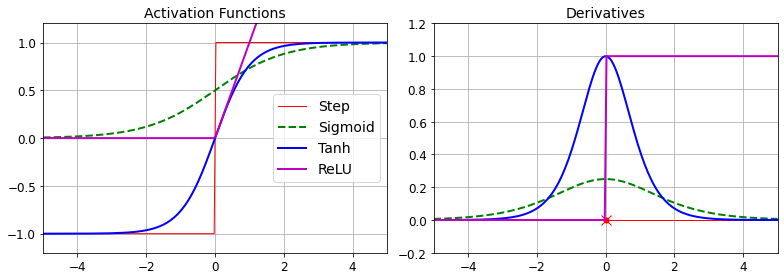

In [105]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(z, np.sign(z), 'r-', label='Step', linewidth=1)
plt.plot(z, sigmoid(z), 'g--', label='Sigmoid', linewidth=2)
plt.plot(z, np.tanh(z), 'b-', label='Tanh', linewidth=2)
plt.plot(z, relu(z), 'm-', label='ReLU', linewidth=2)
plt.grid(True)
plt.legend(loc='center right', fontsize=14)
plt.title('Activation Functions', fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), 'r-', label='Step', linewidth=1)
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), 'g--', label='Sigmoid', linewidth=2)
plt.plot(z, derivative(np.tanh, z), 'b-', label='Tanh', linewidth=2)
plt.plot(z, derivative(relu, z), 'm-', label='ReLU', linewidth=2)
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.title('Derivatives', fontsize=14)

save_fig("activation_functions_plot")
plt.show()

OK! You know where neural nets came from, what their architecture is, and how to compute their outputs. You’ve also learned about the backpropagation algorithm. But what exactly can you do with them?

### Regression MLPs

First, MLPs can be used for regression tasks. If you want to predict a single value (e.g., the price of a house, given many of its features), then you just need a single output neuron: its output is the predicted value. For multivariate regression (i.e., to predict multiple values at once), you need one output neuron per output dimension. For example, to locate the center of an object in an image, you need to predict 2D coordinates, so you need two output neurons. If you also want to place a bounding box around the object, then you need two more numbers: the width and the height of the object. So, you end up with four output neurons. <br>

_**In general, when building an MLP for regression, you do not want to use any activation function for the output neurons, so they are free to output any range of values. If you want to guarantee that the output will always be positive, then you can use the ReLU activation function in the output layer. Alternatively, you can use the `softplus` activation function, which is a smooth variant of ReLU: $softplus(z) = log(1 + exp(z))$. It is close to $0$ when $z$ is negative, and close to $z$ when $z$ is positive. Finally, if you want to guarantee that the predictions will fall within a given range of values, then you can use the logistic function or the hyperbolic tangent, and then scale the labels to the appropriate range: $0$ to $1$ for the logistic function and $–1$ to $1$ for the hyperbolic tangent.**_

**_The loss function to use during training is typically the `mean squared error`, but if you have `a lot of outliers` in the training set, you may prefer to use the `mean absolute error` instead. Alternatively, you can use the `Huber` loss, which is a combination of both._**

### TIP

> The Huber loss is quadratic when the error is smaller than a threshold $δ$ (typically $1$) but linear when the error is larger than $δ$. The linear part makes it less sensitive to outliers than the mean squared error, and the quadratic part allows it to converge faster and be more precise than the mean absolute error.